In [1]:
!pip install catboost
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/BT4222 Data Mining/Code & Data/cleaned_data_with_geo.csv', na_filter=False)
data.drop(['Unnamed: 0', 'property_type', 'latitude', 'longitude', 'X', 'id'], axis=1, inplace=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pd.set_option('display.max_columns', None)
data.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,state,has_license,bathrooms,bathroom_type,num_of_amenities,essentials,luxury,appliances,comfort,entertainment,security,furniture,miscellaneous,host_gender,description_sentiment,neighborhood_overview_sentiment,sentiment_median_score,num_mall_within_500,num_mall_within_1000,num_mall_within_1500,num_mall_within_2000,num_attraction_within_500,num_attraction_within_1000,num_attraction_within_1500,num_attraction_within_2000,mall_within_500,mall_within_1000,mall_within_1500,mall_within_2000,attraction_within_500,attraction_within_1000,attraction_within_1500,attraction_within_2000
0,within an hour,extremely responsive,low,0,1,Entire home/apt,8,2,3,225.0,4,365,0,88,4.7 to 4.8,0,0.59,San Diego,0,2.0,baths,21,2,2,3,1,2,2,0,9,male,Slightly Positive,NA,0.9451,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0
1,within an hour,extremely responsive,average,0,1,Private room,1,1,1,113.0,1,21,20,149,4.3 to 4.4,0,1.02,San Diego,0,1.0,shared,29,4,3,2,2,2,2,1,13,female,Slightly Positive,Slightly Positive,0.9162,0,1,5,8,0,0,0,0,0,1,1,1,0,0,0,0
2,within an hour,extremely responsive,extremely high,1,1,Entire home/apt,7,1,5,258.0,6,365,0,162,4.7 to 4.8,1,1.20,San Diego,0,2.5,baths,41,2,4,8,1,1,3,1,21,female,Neutral,Slightly Positive,0.9245,0,1,2,2,0,0,0,0,0,1,1,1,0,0,0,0
3,within an hour,extremely responsive,extremely high,1,1,Entire home/apt,8,1,6,336.0,6,90,16,183,4.7 to 4.8,1,1.38,San Diego,0,2.0,baths,52,4,5,8,1,2,3,3,26,female,Slightly Positive,Neutral,0.9302,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0
4,within an hour,extremely responsive,high,1,1,Entire home/apt,3,2,3,333.0,5,120,6,296,4.9 to 5.0,0,2.08,San Diego,0,1.0,bath,59,6,3,7,1,2,2,2,36,female,Neutral,Slightly Positive,0.9569,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
data.drop(['num_mall_within_500', 'num_mall_within_1500',	'num_mall_within_2000', 'num_attraction_within_500', 'num_attraction_within_1500',	'num_attraction_within_2000',	'mall_within_500',	'mall_within_1000',	'mall_within_1500',	'mall_within_2000',	'attraction_within_500',	'attraction_within_1000',	'attraction_within_1500',	'attraction_within_2000'], axis=1, inplace=True)

In [4]:
numeric_columns = []
categorical_columns = []
boolean_columns = ['host_is_superhost', 'host_identity_verified', 'has_license', 'instant_bookable']

column_types = data.dtypes
for i in range(len(column_types)):
  if column_types[i] == 'object':
    categorical_columns.append(column_types.index[i])
  elif column_types.index[i] not in boolean_columns and column_types[i] != 'object':
    numeric_columns.append(column_types.index[i])

print(numeric_columns)
print(categorical_columns)
print(boolean_columns)

['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'reviews_per_month', 'bathrooms', 'num_of_amenities', 'essentials', 'luxury', 'appliances', 'comfort', 'entertainment', 'security', 'furniture', 'miscellaneous', 'sentiment_median_score', 'num_mall_within_1000', 'num_attraction_within_1000']
['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'room_type', 'review_scores_rating', 'state', 'bathroom_type', 'host_gender', 'description_sentiment', 'neighborhood_overview_sentiment']
['host_is_superhost', 'host_identity_verified', 'has_license', 'instant_bookable']


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size=0.8)

In [6]:
q3, q1 = np.percentile(train['price'], [75 ,25])
iqr = q3 - q1
lower_bound = max(q1 - 1.5* iqr, 0)
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

0 550.0


In [7]:
train = train[train['price'] <= 543.5]
X_train = train.drop(['price'], axis=1)
y_train = train['price']

test = test[test['price'] <= 543.5]
X_test = test.drop(['price'], axis=1)
y_test = test['price']

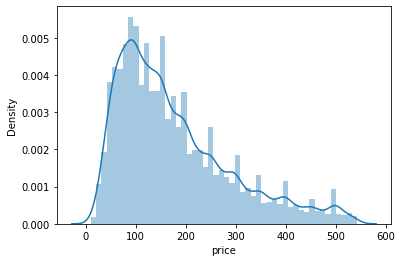

In [26]:
dp = sns.distplot(train['price'])

In [8]:
import random
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [34]:
params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5],
          'iterations': [100, 250, 500, 1000, 2000],
          'border_count': [127, 254, 500],
          }

clf = CatBoostRegressor(cat_features=categorical_columns,
                        random_state=0)

res = clf.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
21:	learn: 66.7073456	test: 70.5087550	best: 70.5087550 (21)	total: 3.22s	remaining: 4m 49s
22:	learn: 66.5354924	test: 70.3869235	best: 70.3869235 (22)	total: 3.33s	remaining: 4m 46s
23:	learn: 66.5275242	test: 70.3926732	best: 70.3869235 (22)	total: 3.43s	remaining: 4m 42s
24:	learn: 66.4285704	test: 70.3491803	best: 70.3491803 (24)	total: 3.57s	remaining: 4m 41s
25:	learn: 66.2895616	test: 70.3334190	best: 70.3334190 (25)	total: 3.72s	remaining: 4m 42s
26:	learn: 66.0741445	test: 70.3556685	best: 70.3334190 (25)	total: 3.84s	remaining: 4m 40s
27:	learn: 65.9060592	test: 70.3296767	best: 70.3296767 (27)	total: 3.98s	remaining: 4m 40s
28:	learn: 65.7287642	test: 70.3344736	best: 70.3296767 (27)	total: 4.1s	remaining: 4m 38s
29:	learn: 65.5699747	test: 70.2526740	best: 70.2526740 (29)	total: 4.24s	remaining: 4m 38s
30:	learn: 65.5616931	test: 70.2524325	best: 70.2524325 (30)	total: 4.35s	remaining: 4m 36s
31:	learn: 65.4206527	test: 70

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_square = r2_score(y_test, y_pred)
print('\nMAE:', mae)
print('\nMSE:', mse)
print('\nRMSE:', rmse)
print('\nR2 Square', r2_square)


MAE: 46.56243963654733

MSE: 4362.781908266475

RMSE: 66.05135811068895

R2 Square 0.6606002007929406


In [36]:
grid_search_results = res['params']
grid_search_results

{'border_count': 254,
 'min_data_in_leaf': 4,
 'depth': 9,
 'max_ctr_complexity': 3,
 'l2_leaf_reg': 4,
 'iterations': 1000,
 'random_strength': 0.8,
 'learning_rate': 0.3333333333333333}

In [ ]:
grid_search_results = {'border_count': 254,
 'min_data_in_leaf': 4,
 'depth': 9,
 'max_ctr_complexity': 3,
 'l2_leaf_reg': 4,
 'iterations': 1000,
 'random_strength': 0.8,
 'learning_rate': 0.3333333333333333}

clf = CatBoostRegressor(cat_features=categorical_columns,
                        random_state=0,
                        **grid_search_results)

clf.fit(X_train, y_train)

In [37]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from catboost import Pool

shap_values = clf.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_columns), type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

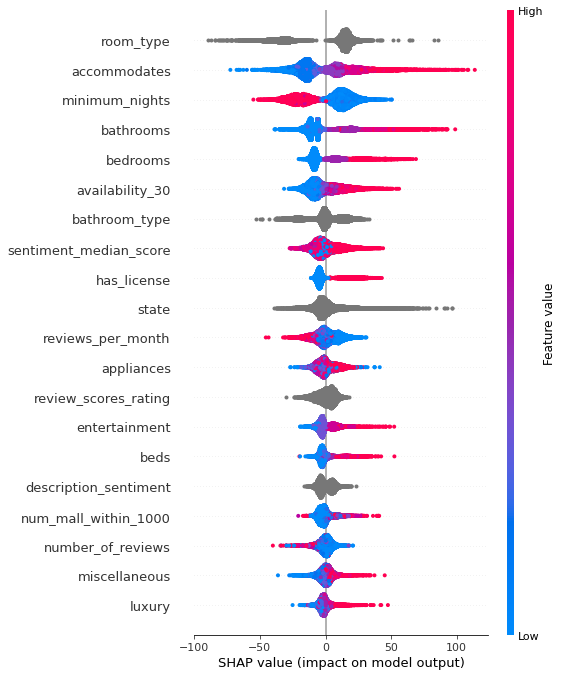

In [39]:
shap_values = clf.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_columns), type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test)

In [42]:
from sklearn.metrics import log_loss

def get_feature_imp_plot(method):
    fi = clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_columns), 
                                                                     type=method)
    
    feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                    columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
    ax.set_xlabel("features")
    plt.show()

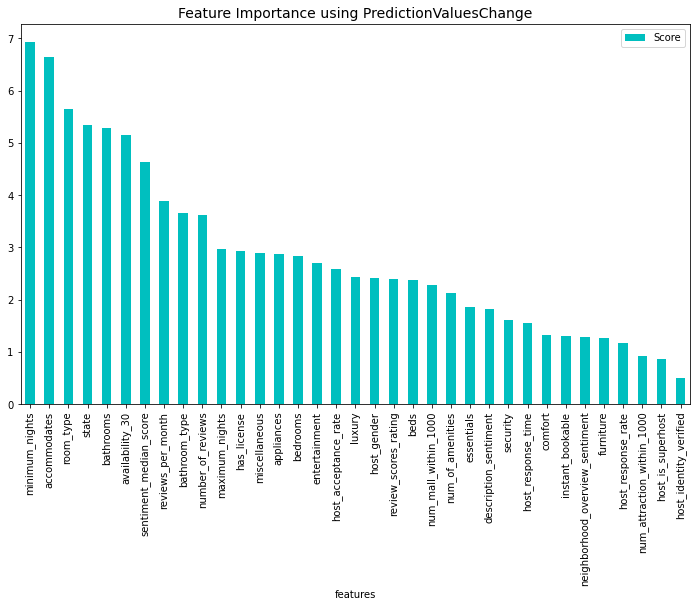

In [43]:
get_feature_imp_plot(method="PredictionValuesChange")

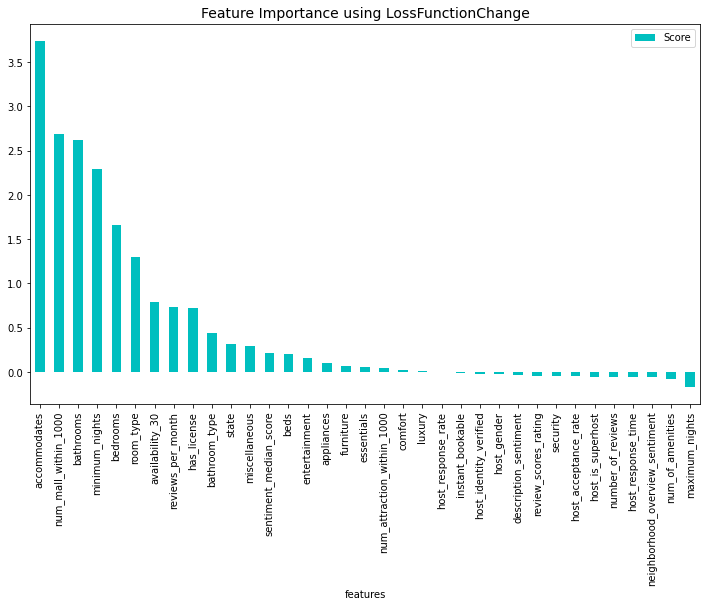

In [41]:
get_feature_imp_plot(method="LossFunctionChange")

In [46]:
pool = Pool(X_train, y_train, cat_features=categorical_columns, feature_names=list(X_train.columns))
tree = clf.plot_tree(tree_idx=0, pool=pool)

In [51]:
tree

In [50]:
tree.render(directory='/content/drive/My Drive/BT4222 Data Mining')

'/content/drive/My Drive/BT4222 Data Mining/tree.pdf'

In [14]:
!pip install pdpbox
import pdpbox
from pdpbox import pdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


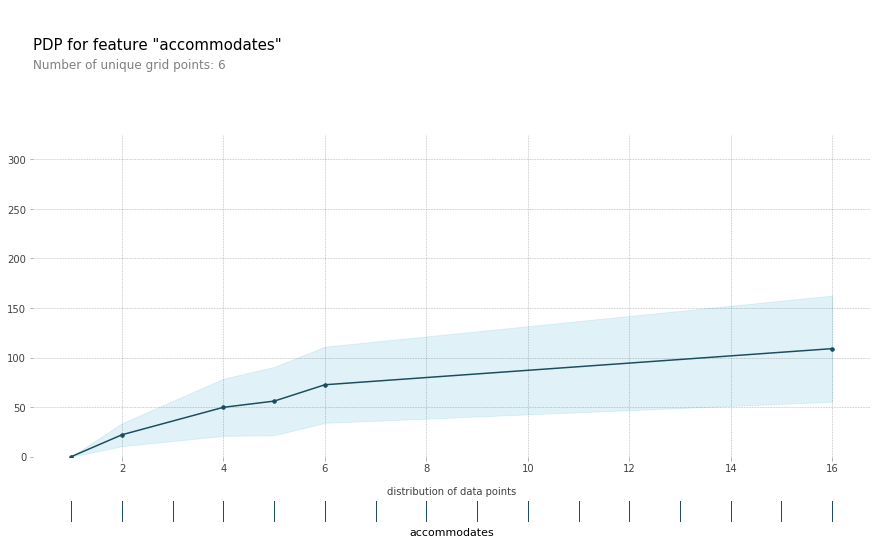

In [15]:
pdp_accommodates = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature='accommodates')
fig, axes = pdp.pdp_plot(pdp_accommodates, 'accommodates', plot_pts_dist=True)

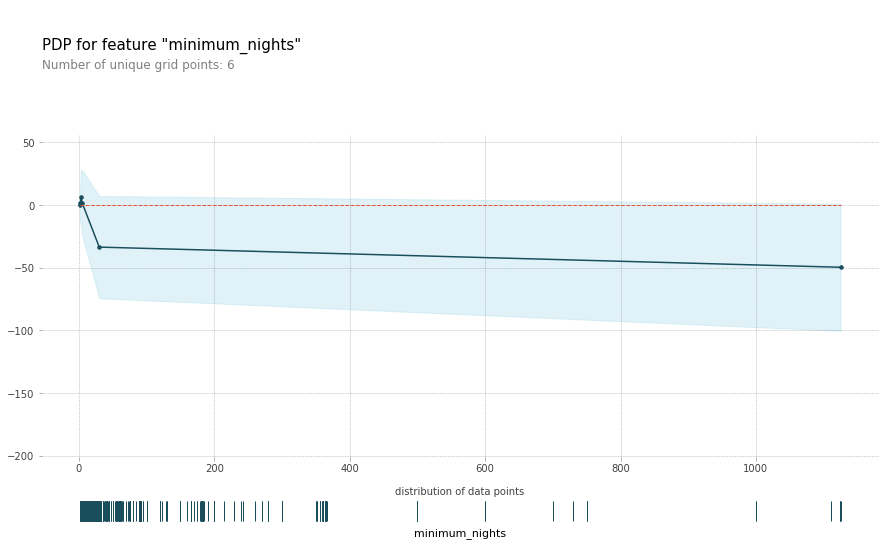

In [18]:
pdp_min_nights = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature='minimum_nights')
fig, axes = pdp.pdp_plot(pdp_min_nights, 'minimum_nights', plot_pts_dist=True)

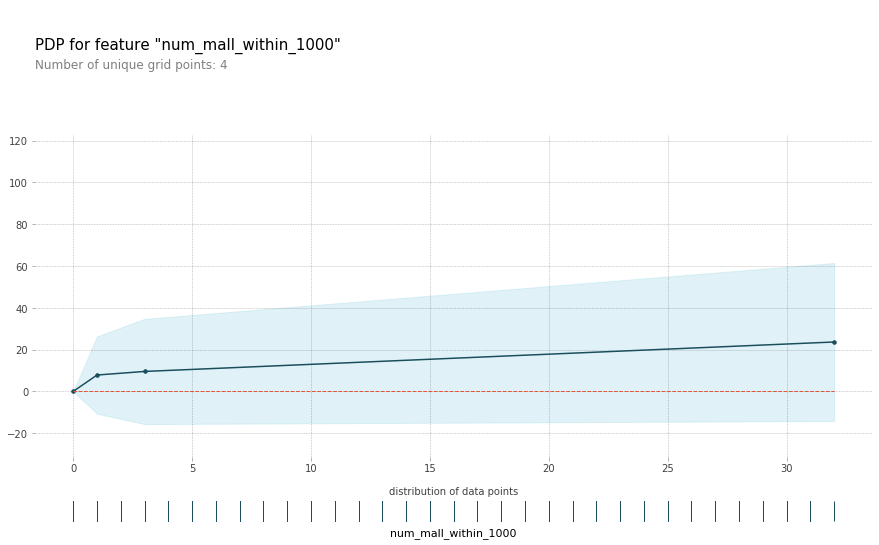

In [22]:
pdp_num_malls = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature='num_mall_within_1000')
fig, axes = pdp.pdp_plot(pdp_num_malls, 'num_mall_within_1000', plot_pts_dist=True)

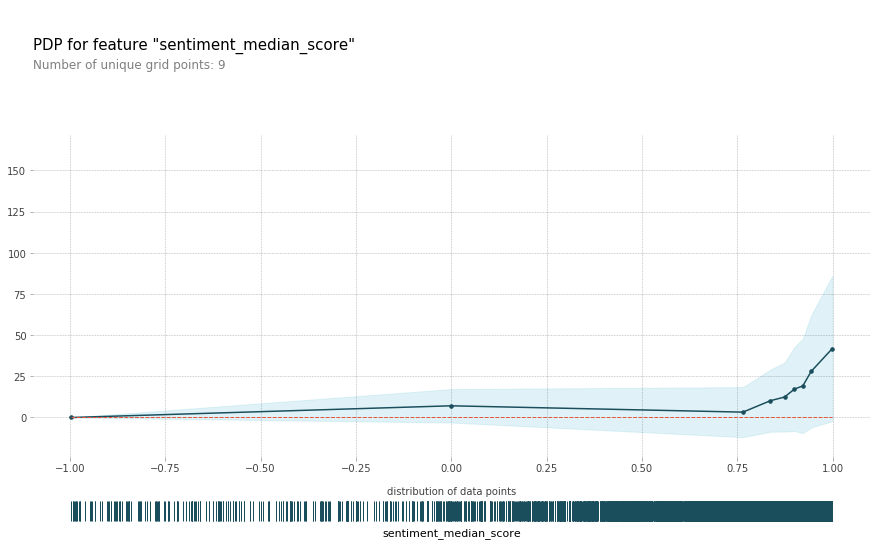

In [20]:
pdp_sentiment = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature='sentiment_median_score')
fig, axes = pdp.pdp_plot(pdp_sentiment, 'sentiment_median_score', plot_pts_dist=True)